In [1]:
import os
from math import ceil
from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import Sequential
from keras.applications import InceptionV3
from keras.layers import Flatten, Dense, Lambda, Convolution2D, MaxPooling2D, Cropping2D, Input, GlobalAveragePooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint, EarlyStopping

/Users/wisnumulya/opt/anaconda3/envs/carnd-term1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/wisnumulya/opt/anaconda3/envs/carnd-term1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/wisnumulya/opt/anaconda3/envs/carnd-term1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Use

In [2]:
df = pd.read_csv('./data/driving_log.csv', header=None,
                 names=['path_center', 'path_left', 'path_right', 'steering', 'throttle', 'brake', 'speed'])
df.head()

,path_center,path_left,path_right,steering,throttle,brake,speed
0,/Users/wisnumulya/Repositories/udacity-self-dr...,/Users/wisnumulya/Repositories/udacity-self-d...,/Users/wisnumulya/Repositories/udacity-self-d...,-0.176955,1.0,0.0,30.18222
1,/Users/wisnumulya/Repositories/udacity-self-dr...,/Users/wisnumulya/Repositories/udacity-self-d...,/Users/wisnumulya/Repositories/udacity-self-d...,-0.186638,1.0,0.0,30.18774
2,/Users/wisnumulya/Repositories/udacity-self-dr...,/Users/wisnumulya/Repositories/udacity-self-d...,/Users/wisnumulya/Repositories/udacity-self-d...,-0.167272,1.0,0.0,30.18970
3,/Users/wisnumulya/Repositories/udacity-self-dr...,/Users/wisnumulya/Repositories/udacity-self-d...,/Users/wisnumulya/Repositories/udacity-self-d...,-0.118857,1.0,0.0,30.19074
4,/Users/wisnumulya/Repositories/udacity-self-dr...,/Users/wisnumulya/Repositories/udacity-self-d...,/Users/wisnumulya/Repositories/udacity-self-d...,0.000000,1.0,0.0,30.18985


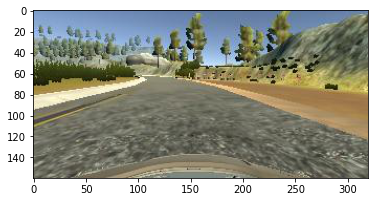

In [3]:
img_paths = df['path_center'].str.split('/').apply(lambda x: './data/IMG/' + x[-1])

plt.imshow(io.imread(img_paths[0]))

In [8]:
images = []
measurements = []

for idx, img_path in enumerate(img_paths):
    img_center = io.imread(img_path)
    steering = float(df['steering'][idx])
    # Read left and right images
    img_left = io.imread(img_path.replace('center', 'left'))
    img_right = io.imread(img_path.replace('center', 'right'))
    correction = 0.2
    steering_left = steering + correction
    steering_right = steering - correction
    
    images.append(img_center)
    measurements.append(steering)
    images.append(img_left)
    measurements.append(steering_left)
    images.append(img_right)
    measurements.append(steering_right)

In [10]:
print(len(images), len(measurements))

15840 15840


In [27]:
df = df.sample(frac=1, random_state=42)

In [28]:
train_samples, validation_samples = train_test_split(df, test_size=0.2)

In [29]:
print(len(train_samples), len(validation_samples))

4224 1056


In [115]:
def sample_generator(samples, batch_size=32):
    """
    A dataset generator which takes a Pandas Dataframe as samples
    and outputs dataset in batches.
    INPUT:
    samples (Pandas DataFrame) - a dataframe of samples
    batch_size (int) - the size of one sample batch to be processed
    OUTPUT:
    X_train (numpy array) - a dataset of images
    y_train (numpy array) - a dataset of steerings
    """
    num_samples = len(samples)
    while True:
        samples = df.sample(frac=1, random_state=42) # shuffle samples in pandas dataframe

        # Create batches of dataset
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size].reset_index(drop=True)

            # Generate images 
            images = []
            steerings = []
            for idx, row in batch_samples.iterrows():
                # Add multiple camera data
                img_center_path = './data/IMG/' + row['path_center'].split('/')[-1]
                img_left_path = img_center_path.replace('center', 'left')
                img_right_path = img_center_path.replace('center', 'right')
                
                img_center = io.imread(img_center_path)
                img_left = io.imread(img_left_path)
                img_right = io.imread(img_right_path)
                center_steering = float(row['steering'])
                correction = 0.2
                left_steering = center_steering + correction
                right_steering = center_steering - correction
                
                # Augment data by flipping horizontally
                img_center_flipped = np.fliplr(img_center)
                img_left_flipped = np.fliplr(img_left)
                img_right_flipped = np.fliplr(img_right)
                center_steering_flipped = -center_steering
                left_steering_flipped = -left_steering
                right_steering_flipped = -right_steering

                # Append multiple camera data and their augmented version
                images.append(img_center)
                steerings.append(center_steering)
                images.append(img_center_flipped)
                steerings.append(center_steering_flip)
                images.append(img_left)
                steerings.append(left_steering)
                images.append(img_left_flipped)
                steerings.append(left_steering_flipped)
                images.append(img_right)
                steerings.append(right_steering)
                images.append(img_right_flipped)
                steerings.append(right_steering_flipped)

            # Transform batch dataset to a numpy array
            X_train = np.array(images)
            y_train = np.array(steerings)
            
            yield shuffle(X_train, y_train)


In [4]:
def build_model():
    """
    Build a model with pretrained AlexNet.
    """
    # Instantiate AlexNet
    inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(139,139,3))

    # Create preprocessing layers
    inp = Input(shape=(160, 320, 3))
    norm = Lambda(lambda x: (x/255)-0.5)(inp) # normalize image
    crop = Cropping2D(cropping=((50, 20), (0,0)))(norm)
    resized = Lambda(lambda x: tf.image.resize_images(x, (139, 139)))(crop)
    
    # Attach the AlexNet with the preprocessing layers
    piped_inception = inception(resized)
    
    # Attach new classifier layers
    avg_pool = GlobalAveragePooling2D()(piped_inception)
    fc = Dense(512, activation='relu')(avg_pool)
    prediction = Dense(1)(fc)
    model = Model(input=inp, output=prediction)

    return model


In [5]:
model = build_model()
model.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 160, 320, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 139, 139, 3)       0         
_________________________________________________________________
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               10

/Users/wisnumulya/opt/anaconda3/envs/carnd-term1/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [107]:
train_generator = sample_generator(train_samples)
validation_generator = sample_generator(validation_samples)

In [113]:
save_path = 'model.h5'
checkpoint = ModelCheckpoint(filepath=save_path, monitor='val_loss', save_best_only=True)
stopper = EarlyStopping(monitor='val_loss', min_delta=0.0003, patience=5)

# Train the model
batch_size = 32
model = build_model()
model.compile(loss='mse', optimizer='adam')

model.fit_generator(train_generator,
                    steps_per_epoch=ceil(len(train_samples)/batch_size),
                    validation_data=validation_generator,
                    validation_steps=ceil(len(validation_samples)/batch_size),
                    callbacks=[checkpoint, stopper],
                    epochs=1)


/Users/wisnumulya/opt/anaconda3/envs/carnd-term1/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/1
132/132 [==============================] - 2356s 18s/step - loss: 0.8805 - val_loss: 0.0286


/Users/wisnumulya/opt/anaconda3/envs/carnd-term1/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


In [108]:
batch_size = 32

model.fit_generator(train_generator,
                    steps_per_epoch=ceil(len(train_samples)/batch_size),
                    validation_data=validation_generator,
                    validation_steps=ceil(len(validation_samples)/batch_size),
                    epochs=1)

model.save('model.h5')
print('Model saved!')

Epoch 1/1
132/132 [==============================] - 2322s 18s/step - loss: 1.0319 - val_loss: 0.0729
Model saved!


In [100]:
batch_size = 32
model = Sequential()
model.add(Lambda(lambda x: (x/255)-0.5, input_shape=(160,320,3))) # normalization
model.add(Cropping2D(cropping=((50, 20), (0,0))))
model.add(Lambda(lambda x: tf.image.resize_images(x, (139, 139)))) # resizing to fit AlexNet
model.add(Convolution2D(filters=96, kernel_size=(11, 11), strides=(4,4),
                        padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator,
                    steps_per_epoch=ceil(len(train_samples)/batch_size),
                    validation_data=validation_generator,
                    validation_steps=ceil(len(validation_samples)/batch_size),
                    epochs=3)

model.save('model.h5')
print('Model saved!')


Epoch 1/3
132/132 [==============================] - 290s 2s/step - loss: 4.1504 - val_loss: 0.0276
Epoch 2/3
132/132 [==============================] - 236s 2s/step - loss: 0.0206 - val_loss: 0.0209
Epoch 3/3
132/132 [==============================] - 237s 2s/step - loss: 0.0173 - val_loss: 0.0205
Model saved!


In [37]:
model = Sequential()
model.add(Lambda(lambda x: (x/255)-0.5))
model.add(Cropping2D(cropping=((50, 20), (0,0)), input_shape=(160,320,3)))
# Conv 1
model.add(Convolution2D(filters=96, kernel_size=(11, 11), strides=(2,2),
                        padding='same', activation='relu'))
model.add(MaxPooling2D())
# Conv 2
model.add(Convolution2D(filters=256, kernel_size=(5, 5), strides=(1,1),
                        padding='same', activation='relu'))
model.add(MaxPooling2D())
# Conv 3
model.add(Convolution2D(filters=384, kernel_size=(3, 3), strides=(1,1),
                        padding='same', activation='relu'))
model.add(MaxPooling2D())
# Conv4
model.add(Convolution2D(filters=384, kernel_size=(3, 3), strides=(1,1),
                        padding='same', activation='relu'))
model.add(MaxPooling2D())
# Conv 5
model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1,1),
                        padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=4)

model.save('model.h5')

Train on 4224 samples, validate on 1056 samples
Epoch 1/4
 128/4224 [..............................] - ETA: 8:27 - loss: 1.5916

KeyboardInterrupt: 